In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras as k
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import Input, Model

Using TensorFlow backend.


# My First Deep Artificial Neural Network
*J. Radford (j.radford.1@research.gla.ac.uk)* <br>

Extreme Light group - Univ. of Glasgow <br>
_(http://www.physics.gla.ac.uk/XtremeLight/index.html)_

<span style="color:gray"><em>Adapted from A. Turpin's ANN intro notebook (16/06/20)</em></span>


Now we have everything installed, **make sure you have the modules imported in the cell above** and lets train the common example of classifying images of handwritten MNIST digits and then apply our knowledge to the regression problem of unscrambling images.

# *Contents*
1. Load and visualise data
2. Define the model
3. Train the model
4. Evaluate the performance of the model
5. Regression example of denoising images


# 1. First we import the training and test data. 

``training data`` - In *supervised learning* the neural network learns by example. We give some training data and then compare the neural network result with the true label. In the case of MNIST classification the images of handwritten number are the input and the label is the output which is just the number that is really in the image. 

``testing data`` - The test data is not used in the training process. We deliberately separate some of our known examples to see how well the model performs after it's done training.


In [2]:
# load data
(x_train, y_train), (x_test, y_test) = k.datasets.mnist.load_data()

# show shape of the data
print('x_train:', x_train.shape,
     '\ny_train:', y_train.shape,
     '\nx_test :', x_test.shape,
     '\ny_test :', y_test.shape
     )

x_train: (60000, 28, 28) 
y_train: (60000,) 
x_test : (10000, 28, 28) 
y_test : (10000,)


- Following convention the inputs images are ``x`` and the output labels are ``y``.

- From the shape we can see that there are 60,000 training images of size (28x28) pixels and then 60,000 corresponsing labels which tell us the true value of the handwritten image.

- In the testing set there are 10,000 images and labels for us to evaluate the performance of our trained model. There is no rule on how much test data is required but I always aim for around 10% of the total data, remember the more training data we use the better our model will learn.

Before we go any further lets look at the data in more detail:

min(x): 0 
max(x): 255 
min(y) : 0 
max(y) : 9


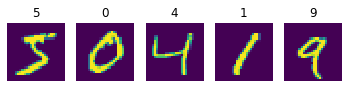

In [3]:
# show the images with the labels as titles
for i in range(5):
    plt.subplot(1,5,i+1)
    
    # plot the first 5 training images
    plt.imshow(x_train[i])
    
    # use the first 5 labels as titles
    plt.title(y_train[i])
    
    #turn off the axis to make it easier to see
    plt.axis('off')
    
# what range of values are in the images
print('min(x):', x_train.min(),
     '\nmax(x):', x_train.max(),
     '\nmin(y) :', y_test.min(),
     '\nmax(y) :', y_test.max()
     )

- We can see that loading in the images has already randomised the order for us.
- The images have values between 0->255 but we should rescale this to be between 0->1 for training neural networks. This is because having large numbers can cause the weights of our model to explode towards infinity.
- There are 10 label classes from 0->9

Now we need to normalise our images:

In [4]:
# Define some useful variables
ntrain = x_train.shape[0] # no. of training images
ntest = x_test.shape[0] # no. of test images
dx = x_train.shape[2] # pixels in x-direction
dy = x_train.shape[1] # pixels in y-direction

# normalise the images between 0->1
x_train = x_train/255
x_test = x_test/255

# reshape images to be row vectors of a large 2D matrix
inp_size = dy*dx
X_train = x_train.reshape((ntrain, inp_size)).astype('float')
X_test = x_test.reshape((ntest, inp_size)).astype('float')

print('X_train:', X_train.shape,
     '\nX_test:', X_test.shape
     )

X_train: (60000, 784) 
X_test: (10000, 784)


# 2. Define the model

There are a two methods for defining a model to be aware of:
- Functional API
- Sequential API

## Functional API

In [5]:
# Clear any previously defined models
if 'model' in locals(): 
    del model
    k.backend.clear_session()

# Option 1: functional API

# define layers
inp = Input(shape=(inp_size,), name='inp_image')
d1 = Dense(32, name='dense_1')(inp)
a1 = Activation('sigmoid', name='activ_1')(d1)
d2 = Dense(16, activation='linear', name='dense_2')(a1)
out = Dense(10, activation='softmax', name='out')(d2)

# Create model
model1 = Model(inputs=inp, outputs=out, name='Fn_API')
model1.summary()

Model: "Fn_API"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp_image (InputLayer)       (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
activ_1 (Activation)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
out (Dense)                  (None, 10)                170       
Total params: 25,818
Trainable params: 25,818
Non-trainable params: 0
_________________________________________________________________


``Input`` - This is the first layer that has a shape to match the number of inputs. In our case each pixel of the input images are an input.

``Dense`` - A dense layer means that each input is connected to every node of the next layer. We've defined ``d1`` to be the second layer which has 64 nodes. Therefore every pixel is connected to all 64 nodes of the next layer and each connection has a *weight* which is a scalar multplication that will be learned.

``Activation`` - Each node in a layer sums it's weighted inputs from the previous layer (remember the *Bias* is also learned and during training and included in the sum) and an activation function determined what value will be passed to the next layer. We've chosen a ``sigmoid`` function in the first layer because it is between zero and one which makes it useful when we want to view the output as a probability of belonging to a class. The next layer is a ``linear`` function which I chose after trying a few and it seems to speed up training. Since we output probabilities the final layer is a ``softmax`` which will ensure all the outputs sum to one.

<center><img src="https://miro.medium.com/max/1192/1*4ZEDRpFuCIpUjNgjDdT2Lg.png" width=500 /></center>
<center><em> Common activation functions used in Neural Networks </em></center>
    
``Model`` - This Keras function takes the input and output layers and creates the model for us. From this info it knows all the other layers since we use the brackets after defining each layer to specify what the input layer was. <br>The idea is to follow this structure: 

```python
layer1 = Input()
layer2 = Dense()(layer1)
layer3 = Activation()(layer2)
layer4 = Dense()(layer3)
```
Note that ``Activation`` layers aren't always necessary we can define an activation function as a parameter in the ``Dense`` function like we did in layer ``d2`` in the code cell above.

``model.summary()`` - Calling the summary function ensures our model is in the sequence we expect and contain all the layers we specified. It's a good way to keep track of the size of each layer and hence, the number of parameters we'll need to learn. Having a large number of parameters makes the training slower and is limited by the computer hardware. This is why having lots of RAM and large memory capacity GPU's are beneficial in machine learning.

<img src="https://thumbs.gfycat.com/WeepyConcreteGemsbok-size_restricted.gif" width=500/>
<center><em>A visual representation of the model we're building. <br>(see the link for a great intro of neural networks: <a href="https://youtu.be/aircAruvnKk">3blue1brown - Neural Networks</a>) </em></center>

In [6]:
# Option 2: Sequential API
model2 = Sequential(name='Seq_API')
model2.add(Dense(64, input_shape=(inp_size,), activation='relu'))
model2.add(Dense(64, activation='linear'))
model2.add(Dense(1))
model2.summary()

Model: "Seq_API"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 54,465
Trainable params: 54,465
Non-trainable params: 0
_________________________________________________________________


The second method is a bit more intuitive, in this case we made a similar model to before but defined the model class first and then add layers using the ``add`` funtion. We can also avoid the ``add`` function completely and pass all our layers at once like this:

In [7]:
# Option 2: Sequential API
model2 = Sequential([
    Dense(64, input_shape=(inp_size,), activation='relu'),
    Dense(64, activation='linear'),
    Dense(1)],
    name='Seq_API')

model2.summary()

Model: "Seq_API"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 54,465
Trainable params: 54,465
Non-trainable params: 0
_________________________________________________________________


# 3. Train the model
Now we've defined a model, we need to compile it and specify which optimisation technique to use and what the loss function will be. After that, we'll be ready to train.

<center><img src="https://thumbs.gfycat.com/MiniatureDependentCob-size_restricted.gif" width=500 /> </center>
<center><em>Visualisation of the training process where all of the weights (connections between nodes) <br>are updated by calculating the gradient of the loss function and performing backpropagation</em></center>

In [8]:
# Compile the model
model1.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 - ``optimizer`` We're using gradient descent so the step we take in the gradient direction on each iteration needs to be determined. In this case we're using a technique developed in http://arxiv.org/abs/1412.6980 to efficiently solve the problem. There are lots of optimizers to try:
     - Adadelta
     - Adagrad
     - Adam
     - Adamax
     - Nadam
     - RMSprop
     - SGD
     
 - ``loss`` This is the objective function we're minimising. Using ``MSE`` (mean squared error) will measure the distance between the network's guess of the label and the actual label.
 
 - ``metrics`` We want to monitor how well the model is doing and ``['accuracy']`` will report the percentage of correct predictions as an output when we're training and testing.

In [9]:
# Train the model
history = model1.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.1
                    )

Train on 54000 samples, validate on 6000 samples
Epoch 1/3
54000/54000 [==============================] - 2s 41us/step - loss: 0.6352 - accuracy: 0.8377 - val_loss: 0.2479 - val_accuracy: 0.9340
Epoch 2/3
54000/54000 [==============================] - 2s 35us/step - loss: 0.2568 - accuracy: 0.9258 - val_loss: 0.1882 - val_accuracy: 0.9482
Epoch 3/3
54000/54000 [==============================] - 2s 34us/step - loss: 0.2029 - accuracy: 0.9413 - val_loss: 0.1616 - val_accuracy: 0.9528


``history`` - The output of ``model.fit()`` will give us information about the training progress of the model. It's useful for spotting *over-fitting* and *under-fitting* (<a href="https://en.wikipedia.org/wiki/Overfitting">Wikipedia: Overfitting</a>) which in machine learning terms is linked to the trade-off between *bias (accuracy)* and *variance (precision)* of the model (<a href="https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff">Wikipedia: Bias-variance trade-off</a>).

``batch_size`` - Calculating the gradient for the entire 60,000 training images and labels at once is computationally expensive, so we break it up into chunks of 64 instead. Calculating the gradient ~1,000 times on chunks of 64 is much quicker and we can optimise the computer hardware to accelerate the training.

``epochs`` - Often confused with *iterations* which is the evaluation of the gradient over each training batch, the number of epoch is how many times we go through the entire training dataset. We do this because the model might have performed poorly on the first 64 images and found the direction of steepest descent but by the time it has done this on all 54,000 images, it will perform differently on the same first 64 the next time round. The more training data and epoch we have, the better performance we can get out of our model.

``validation_split`` - Overfitting is a problem whereby we have a model that performs very well when given the training data but is very sensitive to small changes in the input which might cause bad performance on the test set. Overfitting is often caused by how we defined our model in the first place (e.g. too many nodes or too many layers). To mitigate this we save a small amount of the training data for testing the model as we train (this is not used to update our weights, it only gives us a score for how well the model performs on unseen data). If the validation accuracy is very low but the training accuracy is high then we should try changing some properties of the model until the validation accuracy is as good, or as close as possible, to the training accuracy. The ``validation_split`` parameter is the ratio of training data we want to hold back, remember the more training data we have the better our model is likely to perform, so here we only take 10%. <em>(P.s. Validation data can also be used to tune the hyper-parameters of our model in an autonomous way using methods such as Gaussian Processes. There is a good intro to the GPy library <a href="https://www.wouterbulten.nl/blog/tech/first-steps-with-gpy">here</a> that gives a rough overview of how to do this.)</em>


# 4. Evaluate the performance of the model

Now the model is has trained we can test it's performance on the test set which it has never seen before.

In [10]:
# Evaluate model on test data
results = model1.evaluate(X_test, y_test)
print('loss: {:.3f}, acc: {:.3f}'.format(results[0],results[1]))

10000/10000 [==============================] - 0s 35us/step
loss: 0.188, acc: 0.943


Great, it seems that the accuracy is still very high. We can also get the output probabilities of the model when given some of our test data:

In [11]:
# Show the output for the first 5 test images
predict = model1.predict(X_test[0:5])

# print the probability of lying in each class 
# for the first test image
print("Probabilities of being in classes for the 1st test image:\n", predict[0])

# print the most likely class
print('\nThe first test image is most likely to be:', predict[0].argmax())

Probabilities of being in classes for the 1st test image:
 [1.39239455e-05 7.07055563e-07 1.68469545e-04 7.88579346e-04
 1.00799092e-07 3.89134675e-06 4.82487994e-10 9.98722374e-01
 1.44222679e-06 3.00431420e-04]

The first test image is most likely to be: 7


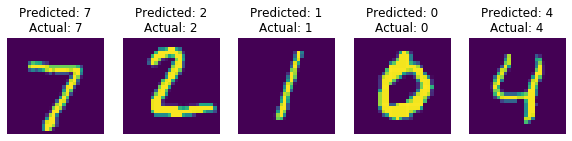

In [12]:
# Plot showing images and predictions
plt.figure(figsize=(10,5))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title('Predicted: {}\nActual: {}'.format(predict[i].argmax(), y_test[i]))

Here's how to visualise the training history, which has information about the accuracy of predicting the training data and the validation data per epoch:

In [13]:
# what does the history.history dictionary contain?
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


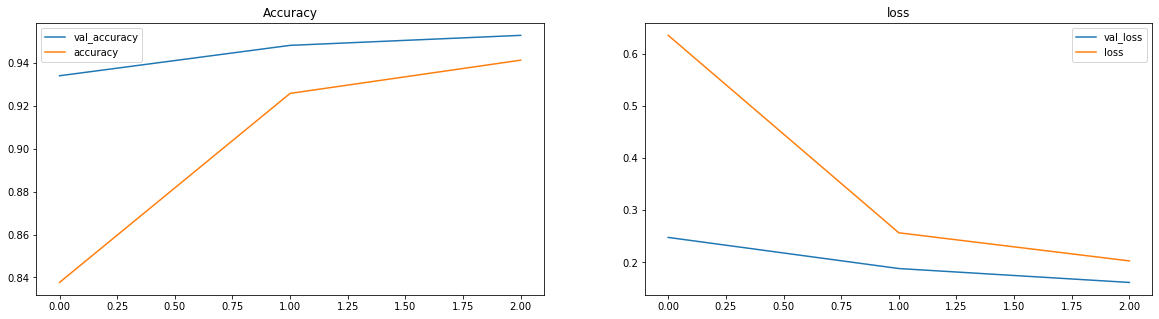

In [14]:
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
# Plot Accuracy
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
# Plot loss
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['loss'], label='loss')
plt.title('loss')
plt.legend()


The plots aren't very exciting since we only ran for 3 epochs and I chose a very good model for this type of problem but if we were to try changing the loss to ``MSE`` (mean squared error) and run it for 40 epochs then it might give a sttep curve with a nice platau.

# 5. Regression example of denoising images

The task now is to not make a classifier but output an image of the same size as the input. An easy example to demonstrate is image denoising which is a useful tool to have when the noise is non-linear or the statistics of noise are unknown.

progress:0/60000
progress:10000/60000
progress:20000/60000
progress:30000/60000
progress:40000/60000
progress:50000/60000


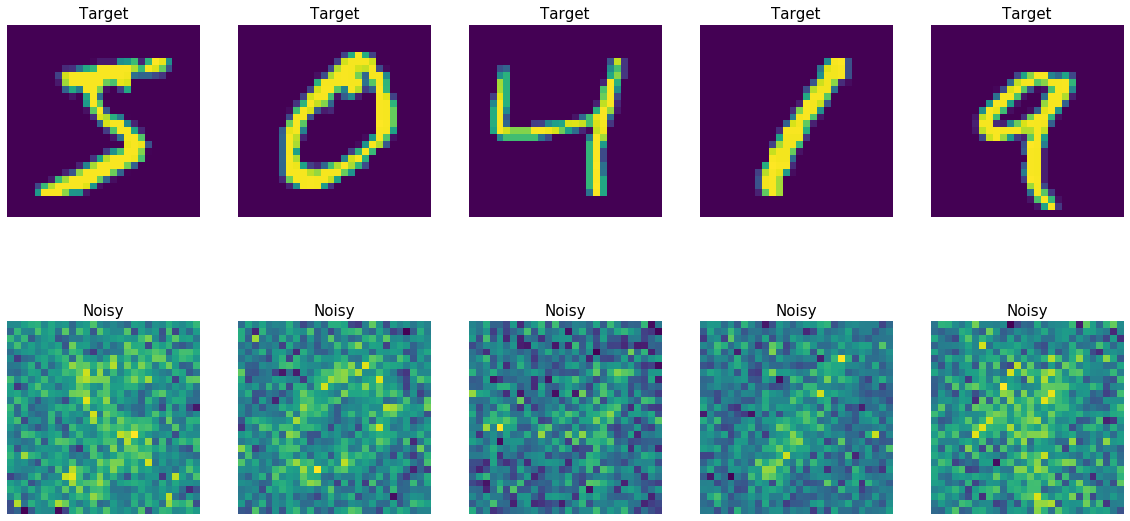

In [15]:
# prepare some noisy images using a
# blurring kernel and adding random
# values from a normal distribution

# import OpenCV (cv2) image toolkit library
import cv2

# Define the mean and st. dev of normal
mean = 0.4
std = 0.4

# create placeholders for noisy image arrays
x_train_noisy = np.zeros(x_train.shape)
x_test_noisy = np.zeros(x_test.shape)

# create noisy training images
for i in range(x_train.shape[0]):
    x_train_noisy[i] = cv2.blur(x_train[i], (5,5))
    x_train_noisy[i] = x_train_noisy[i] + np.random.randn(dx,dy)*std+mean
    if np.mod(i,1e4)==0:
        print('progress:{}/{}'.format(i, x_train.shape[0]))

# create noisy test images
for i in range(x_test.shape[0]):
    x_test_noisy[i] = cv2.blur(x_test[i], (5,5))
    x_test_noisy[i] = x_test_noisy[i] + np.random.randn(dx,dy)*std+mean
    
# show some examples
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[i])
    plt.axis('off')
    plt.title('Target', size=15)
    
    plt.subplot(2, 5, i+1+5)
    plt.imshow(x_train_noisy[i])
    plt.axis('off')
    plt.title('Noisy', size=15)
    

In [16]:
# reshape the images to row vectors
x_train_noisy = x_train_noisy.reshape(ntrain, dx*dy)
x_test_noisy = x_test_noisy.reshape(ntest, dx*dy)

In [17]:
# create denoise model
denoiser = Sequential([
    Dense(128, input_shape=(inp_size,), activation='relu'),
    Dense(128, activation='relu'),
    Dense(inp_size, activation='sigmoid')],
    name='Img_Denoiser')

# compile model
denoiser.compile(optimizer='Adam',
                loss='mse',
                metrics=['accuracy']
                )

# train the model
history2 = denoiser.fit(x_train_noisy, X_train,
                       epochs=10
                       )

Epoch 1/10
60000/60000 [==============================] - 5s 79us/step - loss: 0.0390 - accuracy: 0.0097
Epoch 2/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0286 - accuracy: 0.0104
Epoch 3/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0267 - accuracy: 0.0110
Epoch 4/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0257 - accuracy: 0.0121
Epoch 5/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0250 - accuracy: 0.0116
Epoch 6/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0246 - accuracy: 0.0120
Epoch 7/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0243 - accuracy: 0.0119
Epoch 8/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0240 - accuracy: 0.0120
Epoch 9/10
60000/60000 [==============================] - 5s 77us/step - loss: 0.0238 - accuracy: 0.0124
Epoch 10/10
60000/60000 [==============================

In [18]:
results = denoiser.evaluate(x_test_noisy, X_test)
print('loss: {:.3f}, acc: {:.3f}'.format(results[0],results[1]))

10000/10000 [==============================] - 0s 43us/step
loss: 0.024, acc: 0.012


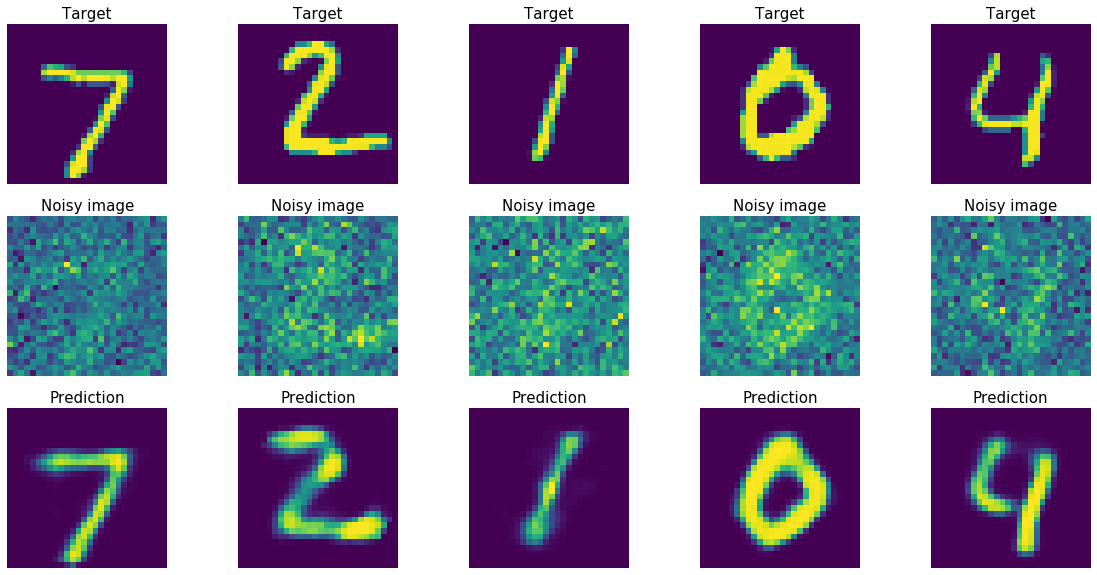

In [19]:
# make some predictions
predict = denoiser.predict(x_test_noisy[0:5])
predict = predict.reshape(predict.shape[0], dx, dy)
noisy = x_test_noisy.reshape(x_test_noisy.shape[0], dx, dy)

plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.title('Target', size=15)

    plt.subplot(3, 5, i+6)
    plt.imshow(noisy[i])
    plt.axis('off')
    plt.title('Noisy image', size=15)
    
    plt.subplot(3, 5, i+11)
    plt.imshow(predict[i])
    plt.axis('off')
    plt.title('Prediction', size=15)

It's not perfect, but pretty impressive. I used sigmoid activations because I knew the output was binary but the rest is mainly trial and error. It's better to use convolutional neural networks (CNNs) for dealing with images which should show even better results with less computational cost. I have another tutorial on what they are and how they work.